# WeRateDogs Data Wrangling.

- <a href="#gathering"> Data Gathering </a>
- <a href="#assessing"> Data Assessing </a> 
- <a href="#cleaning"> Data Cleaning </a>
- <a href='#analize'> Analyzing and Visualizing <a/>

In [1]:
import pandas as pd 
import requests 
import os 
from bs4 import BeautifulSoup
import string
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import numpy as np
import urllib3
from datetime import datetime
import time 
import re
from PIL import Image
import io
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud  import WordCloud,ImageColorGenerator
%matplotlib inline
urllib3.disable_warnings()

___________________

<a id='gathering'></a>
## Gathering


In this section i am going to gather data from four different sources.<br>
These sources are:
- <a href="#gathering1">A pre-given file contains basic tweet data for tweets tweeted by WeRateDoges account.</a>
- <a href="#gathering2">Programmatically downloading a file contains predictions of the dog breed in each tweet in the Enhanced Twitter Archive </a>
- <a href="#gathering3">Scraping data regarding dog breeds from the American Kennel Club</a>
- <a href="#gathering4">Additional Data via the Twitter API regarding the tweets given in the Enhanced Twitter Archive</a>



<a id='gathering1'></a>
### Enhanced Twitter Archive.


Here i am going to load the pre-given Enhanced Twitter Archive CSV file into a DataFrame.

In [2]:
twitter_archive = pd.read_csv('./twitter-archive-enhanced.csv')

twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


<a id='gathering2'></a>
### Image Predictions.

The Image Predictions file is hosted on Udacity's servers so i am going to download it programmatically then loading it into DataFrame.

In [3]:
if not os.path.exists('./image_predictions.tsv'):
    
    url_image_predictions='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    r = requests.get(url_image_predictions)
    
    with open('image_predictions.tsv',mode='wb') as file:
        
        file.write(r.content)
        
        
image_predictions=pd.read_csv('./image_predictions.tsv',sep='\t')
image_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


<a id='gathering3'></a>
### AKC dog breeds.


In this part of the Gathering process i am gonna scrape data regarding dog breeds from [AKC website](https://www.akc.org/).

In [3]:
akc_breeds_url = 'https://www.akc.org/dog-breeds/' # the url of the page that contains all dog breeds
akc_breeds_response = requests.get(akc_breeds_url,verify=False) # requesting the page that contains all dog breeds
akc_breeds_soup = BeautifulSoup(akc_breeds_response.content) # getting the soup of that page
akc_breeds_list = []
count = 1 # a counter to count each process of sucess of scraping data of one dog breed

# looping over the breeds letters filter in the ack_breeds_soup 
# the If statement in the loop skips the letters Q ,U and Z cause there're no breeds' names start with these letters

for letter_div in akc_breeds_soup.find_all('div',class_='breed-letters-filter__letter'):
    if letter_div.span.contents[0] in ('Q','U','Z'):
        continue
    else: # else get the letter and request the first page of the letter and get the soup of this page 
        letter = letter_div.span.contents[0]
        page_number = 1
        letter_url = 'https://www.akc.org/dog-breeds/page/'+str(page_number)+'/?letter='+letter
        letter_page = requests.get(letter_url)
        letter_page_soup = BeautifulSoup(letter_page.content)
        while letter_page_soup.body['class'][0] != 'error404': # this while loop loops over all the pages of a letter starting 
            #from page_number equal one then incrementing the page_number by one for each loop until getting error404 which 
            #means the page is not found so we move to the next letter 
            for breed_a in letter_page_soup.find_all('a',class_='link-with-arrow'):#now looping over each breed in a letter page
                print(count,end=',') #printing the counter
                count += 1 # incrementing the counter
                
                breed_page = requests.get(breed_a['href'],verify = False) # requesting the breed page
                breed_soup = BeautifulSoup(breed_page.content) # getting the soup of the breed page
                breed_url = breed_a['href'] #getting the url of the breed page from the soup
                breed_name = breed_soup.h1.contents[0].strip() #getting the breed name from the soup
                # the If statements down here overcome the issue that some of the pages have missing values
                if len(breed_soup.find_all(text='Temperament:')) == 0:
                    breed_temperament = None
                else:
                    breed_temperament = breed_soup.find_all(text='Temperament:')[0].next.next.next.split(',')
                    
                if len(breed_soup.find_all(text='AKC Breed Popularity:')) == 0:
                    akc_breed_popularity = None
                else:
                    akc_breed_popularity = breed_soup.find_all(text='AKC Breed Popularity:')[0].next.next.contents[0]
                    
                if len(breed_soup.find_all(text='Height:')) == 0:
                    breed_height = None
                else:
                    breed_height = breed_soup.find_all(text='Height:')[0].next.next.contents[0]
                    
                if len(breed_soup.find_all(text='Weight:')) == 0:
                    breed_weight = None
                else:
                    breed_weight = breed_soup.find_all(text='Weight:')[0].next.next.contents[0]
                    
                if len(breed_soup.find_all(text='Life Expectancy:')) == 0:
                    breed_life_expectancy = None
                else:
                    breed_life_expectancy = breed_soup.find_all(text='Life Expectancy:')[0].next.next.contents[0]
                        
                if len(breed_soup.find_all(text='Group:')) == 0:
                    breed_group = None
                else:
                    breed_group = breed_soup.find_all(text='Group:')[0].next.next.a.contents[0]
                    
                if breed_soup.find('a',class_='button button--secondary button--ghost') is None:
                    akc_breed_standard = None
                else:
                    akc_breed_standard = breed_soup.find('a',class_='button button--secondary button--ghost')['href']
                         
                breed_image = breed_soup.find('img',class_='tabs-with-image__aside-image lozad')['data-src']
                # appending all the scraped values to a list as a dictionary type
                akc_breeds_list.append({'breed':breed_name, 
                                'breed_url':breed_url,
                                'breed_image':breed_image,
                                'breed_group':breed_group,
                                'weight':breed_weight,
                                'height':breed_height,
                                'life_expectancy':breed_life_expectancy,
                                'breed_temperament':breed_temperament,
                                 'pdf_breed_standard':akc_breed_standard,
                                'akc_breed_popularity':akc_breed_popularity})
            page_number += 1 #incrementing the page number
            letter_url = 'https://www.akc.org/dog-breeds/page/'+str(page_number)+'/?letter='+letter #changing the letter page to the next page incremented page
            letter_page = requests.get(letter_url) # getting the response of the next page
            letter_page_soup = BeautifulSoup(letter_page.content)  # getting the soup of the next page
print('\n','All Done')
        
akc_breeds = pd.DataFrame(akc_breeds_list) #loading the scraped values into a DataFrame

akc_breeds.head(1)

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

,breed,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity
0,Affenpinscher,https://www.akc.org/dog-breeds/affenpinscher/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Toy Group,7-10 pounds,9-11.5 inches,12-15 years,"[Confident, Famously Funny, Fearless]",http://images.akc.org/pdf/breeds/standards/Aff...,Ranks 148 of 195


In [5]:
akc_breeds.to_csv('akc_breeds.csv')

<a id='gathering4'></a>
### Twitter API data.

The last data to gather are each tweet's retweet count and favorite and some other additional data regarding the tweets given in the Enhanced Twitter Archive data.

In [5]:
# the code in this cell used in the authentication process and for calling the api.
consumer_key='****'
consumer_secret='****'
access_token='****'
access_token_secret='****'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit_notify=True,wait_on_rate_limit=True)


The code in the cell bellow used to get info about WeRateDogs account. 

In [6]:
we_rate_dogs=api.get_user('dog_rates')
print('The screen name, handle, or alias that this user identifies themselves with:',we_rate_dogs.screen_name) 
print('The name of the user, as they’ve defined it:',we_rate_dogs.name) 
print('The UTC datetime that the user account was created on Twitter:',we_rate_dogs.created_at)
print('The user-defined UTF-8 string describing their account:',we_rate_dogs.description) 
print('The number of Tweets this user has liked in the account’s lifetime:',str(we_rate_dogs.favourites_count))
print('The number of followers this account currently has:',str(we_rate_dogs.followers_count))
print('The number of users this account is following:',str(we_rate_dogs.friends_count))
print('The number of Tweets (including retweets) issued by the user:',str(we_rate_dogs.statuses_count))
print('The number of public lists that this user is a member of:',str(we_rate_dogs.statuses_count))
print('\n','These informations above have been taken on:',datetime.utcnow(),'UTC')



The screen name, handle, or alias that this user identifies themselves with: dog_rates
The name of the user, as they’ve defined it: WeRateDogs®
The UTC datetime that the user account was created on Twitter: 2015-11-15 21:41:29
The user-defined UTF-8 string describing their account: Your Only Source For Professional Dog Ratings Instagram and Facebook ➪ WeRateDogs partnerships@weratedogs.com ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
The number of Tweets this user has liked in the account’s lifetime: 144416
The number of followers this account currently has: 8627728
The number of users this account is following: 14
The number of Tweets (including retweets) issued by the user: 11454
The number of public lists that this user is a member of: 11454

 These informations above have been taken on: 2020-01-19 22:42:11.845196 UTC


In [7]:
tweet_ids=twitter_archive.tweet_id.values # getting the ids of all the tweets in the twitter_archive dataframe
count = 1 # counter to count each excuted tweet.
fails_dict = {} # dictionary with keys of tweets' ids failed to excute and values of stings showing the errors why these tweets faild to excute.
start = timer() #starting timer.
with open('tweet_json.txt',mode='w') as file: #creating a text file in the writing mode.
    for tweet_id in tweet_ids: # looping over the tweet_ids from twitter_archive data.
        print(str(count)+':'+str(tweet_id)) #printing the tweet count and the tweet_id.
        count+=1
        #if no error occures during the execution of getting the status then write the tweet's Json code in twitter_json.txt file and print Success.
        try:
            tweet=api.get_status(tweet_id,tweet_mode='extended')._json 
            json.dump(tweet, file)
            file.write('\n')
            print('Success')
        #if any error occures print fail and add the id of the faild tweet as key and the error as a value to this key in fails_dict dictionary then print Fail
        except tweepy.TweepError as error:
            print('Fail')
            fails_dict[tweet_id]=error

end = timer() #ending timer.
print(end - start) #printing time between starting and ending timers .
print(fails_dict) 

1:892420643555336193
Success
2:892177421306343426
Success
3:891815181378084864
Success
4:891689557279858688
Success
5:891327558926688256
Success
6:891087950875897856
Success
7:890971913173991426
Success
8:890729181411237888
Success
9:890609185150312448
Success
10:890240255349198849
Success
11:890006608113172480
Success
12:889880896479866881
Success
13:889665388333682689
Success
14:889638837579907072
Success
15:889531135344209921
Success
16:889278841981685760
Success
17:888917238123831296
Success
18:888804989199671297
Success
19:888554962724278272
Success
20:888202515573088257
Fail
21:888078434458587136
Success
22:887705289381826560
Success
23:887517139158093824
Success
24:887473957103951883
Success
25:887343217045368832
Success
26:887101392804085760
Success
27:886983233522544640
Success
28:886736880519319552
Success
29:886680336477933568
Success
30:886366144734445568
Success
31:886267009285017600
Success
32:886258384151887873
Success
33:886054160059072513
Success
34:885984800019947520


Success
271:841314665196081154
Success
272:841077006473256960
Success
273:840761248237133825
Success
274:840728873075638272
Success
275:840698636975636481
Success
276:840696689258311684
Success
277:840632337062862849
Success
278:840370681858686976
Success
279:840268004936019968
Success
280:839990271299457024
Success
281:839549326359670784
Success
282:839290600511926273
Success
283:839239871831150596
Success
284:838952994649550848
Success
285:838921590096166913
Success
286:838916489579200512
Success
287:838831947270979586
Success
288:838561493054533637
Success
289:838476387338051585
Success
290:838201503651401729
Success
291:838150277551247360
Success
292:838085839343206401
Success
293:838083903487373313
Success
294:837820167694528512
Success
295:837482249356513284
Success
296:837471256429613056
Success
297:837366284874571778
Fail
298:837110210464448512
Success
299:837012587749474308
Fail
300:836989968035819520
Success
301:836753516572119041
Success
302:836677758902222849
Success
303:83

Success
536:807059379405148160
Success
537:807010152071229440
Success
538:806629075125202948
Success
539:806620845233815552
Success
540:806576416489959424
Success
541:806542213899489280
Success
542:806242860592926720
Success
543:806219024703037440
Success
544:805958939288408065
Success
545:805932879469572096
Success
546:805826884734976000
Success
547:805823200554876929
Success
548:805520635690676224
Success
549:805487436403003392
Success
550:805207613751304193
Success
551:804738756058218496
Success
552:804475857670639616
Success
553:804413760345620481
Success
554:804026241225523202
Success
555:803773340896923648
Success
556:803692223237865472
Success
557:803638050916102144
Success
558:803380650405482500
Success
559:803321560782307329
Success
560:803276597545603072
Success
561:802952499103731712
Success
562:802624713319034886
Success
563:802600418706604034
Success
564:802572683846291456
Success
565:802323869084381190
Success
566:802265048156610565
Success
567:802247111496568832
Fail
568

Success
801:772615324260794368
Success
802:772581559778025472
Success
803:772193107915964416
Success
804:772152991789019136
Success
805:772117678702071809
Success
806:772114945936949249
Success
807:772102971039580160
Success
808:771908950375665664
Success
809:771770456517009408
Success
810:771500966810099713
Success
811:771380798096281600
Success
812:771171053431250945
Success
813:771136648247640064
Success
814:771102124360998913
Success
815:771014301343748096
Success
816:771004394259247104
Success
817:770787852854652928
Success
818:770772759874076672
Success
819:770743923962707968
Fail
820:770655142660169732
Success
821:770414278348247044
Success
822:770293558247038976
Success
823:770093767776997377
Success
824:770069151037685760
Success
825:769940425801170949
Success
826:769695466921623552
Success
827:769335591808995329
Success
828:769212283578875904
Success
829:768970937022709760
Success
830:768909767477751808
Success
831:768855141948723200
Success
832:768609597686943744
Success
833

Rate limit reached. Sleeping for: 266


Success
902:758474966123810816
Success
903:758467244762497024
Success
904:758405701903519748
Success
905:758355060040593408
Success
906:758099635764359168
Success
907:758041019896193024
Success
908:757741869644341248
Success
909:757729163776290825
Success
910:757725642876129280
Success
911:757611664640446465
Success
912:757597904299253760
Success
913:757596066325864448
Success
914:757400162377592832
Success
915:757393109802180609
Success
916:757354760399941633
Success
917:756998049151549440
Success
918:756939218950160384
Success
919:756651752796094464
Success
920:756526248105566208
Success
921:756303284449767430
Success
922:756288534030475264
Success
923:756275833623502848
Success
924:755955933503782912
Success
925:755206590534418437
Success
926:755110668769038337
Success
927:754874841593970688
Success
928:754856583969079297
Success
929:754747087846248448
Success
930:754482103782404096
Success
931:754449512966619136
Success
932:754120377874386944
Success
933:754011816964026368
Fail
934

Success
1162:723912936180330496
Success
1163:723688335806480385
Success
1164:723673163800948736
Success
1165:723179728551723008
Success
1166:722974582966214656
Success
1167:722613351520608256
Success
1168:721503162398597120
Success
1169:721001180231503872
Success
1170:720785406564900865
Success
1171:720775346191278080
Success
1172:720415127506415616
Success
1173:720389942216527872
Success
1174:720340705894408192
Success
1175:720059472081784833
Success
1176:720043174954147842
Success
1177:719991154352222208
Success
1178:719704490224398336
Success
1179:719551379208073216
Success
1180:719367763014393856
Success
1181:719339463458033665
Success
1182:719332531645071360
Success
1183:718971898235854848
Success
1184:718939241951195136
Success
1185:718631497683582976
Success
1186:718613305783398402
Success
1187:718540630683709445
Success
1188:718460005985447936
Success
1189:718454725339934721
Success
1190:718246886998687744
Success
1191:718234618122661888
Success
1192:717841801130979328
Success


Success
1419:698355670425473025
Success
1420:698342080612007937
Success
1421:698262614669991936
Success
1422:698195409219559425
Success
1423:698178924120031232
Success
1424:697995514407682048
Success
1425:697990423684476929
Success
1426:697943111201378304
Success
1427:697881462549430272
Success
1428:697630435728322560
Success
1429:697616773278015490
Success
1430:697596423848730625
Success
1431:697575480820686848
Success
1432:697516214579523584
Success
1433:697482927769255936
Success
1434:697463031882764288
Success
1435:697270446429966336
Success
1436:697259378236399616
Success
1437:697255105972801536
Success
1438:697242256848379904
Success
1439:696900204696625153
Success
1440:696894894812565505
Success
1441:696886256886657024
Success
1442:696877980375769088
Success
1443:696754882863349760
Success
1444:696744641916489729
Success
1445:696713835009417216
Success
1446:696518437233913856
Success
1447:696490539101908992
Success
1448:696488710901260288
Success
1449:696405997980676096
Success


Success
1676:682242692827447297
Success
1677:682088079302213632
Success
1678:682059653698686977
Success
1679:682047327939461121
Success
1680:682032003584274432
Success
1681:682003177596559360
Success
1682:681981167097122816
Success
1683:681891461017812993
Success
1684:681694085539872773
Success
1685:681679526984871937
Success
1686:681654059175129088
Success
1687:681610798867845120
Success
1688:681579835668455424
Success
1689:681523177663676416
Success
1690:681340665377193984
Success
1691:681339448655802368
Success
1692:681320187870711809
Success
1693:681302363064414209
Success
1694:681297372102656000
Success
1695:681281657291280384
Success
1696:681261549936340994
Success
1697:681242418453299201
Success
1698:681231109724700672
Success
1699:681193455364796417
Success
1700:680970795137544192
Success
1701:680959110691590145
Success
1702:680940246314430465
Success
1703:680934982542561280
Success
1704:680913438424612864
Success
1705:680889648562991104
Success
1706:680836378243002368
Success


Rate limit reached. Sleeping for: 271


Success
1802:676957860086095872
Success
1803:676949632774234114
Success
1804:676948236477857792
Success
1805:676946864479084545
Success
1806:676942428000112642
Success
1807:676936541936185344
Success
1808:676916996760600576
Success
1809:676897532954456065
Success
1810:676864501615042560
Success
1811:676821958043033607
Success
1812:676819651066732545
Success
1813:676811746707918848
Success
1814:676776431406465024
Success
1815:676617503762681856
Success
1816:676613908052996102
Success
1817:676606785097199616
Success
1818:676603393314578432
Success
1819:676593408224403456
Success
1820:676590572941893632
Success
1821:676588346097852417
Success
1822:676582956622721024
Success
1823:676575501977128964
Success
1824:676533798876651520
Success
1825:676496375194980353
Success
1826:676470639084101634
Success
1827:676440007570247681
Success
1828:676430933382295552
Success
1829:676263575653122048
Success
1830:676237365392908289
Success
1831:676219687039057920
Success
1832:676215927814406144
Success


Success
2059:671347597085433856
Success
2060:671186162933985280
Success
2061:671182547775299584
Success
2062:671166507850801152
Success
2063:671163268581498880
Success
2064:671159727754231808
Success
2065:671154572044468225
Success
2066:671151324042559489
Success
2067:671147085991960577
Success
2068:671141549288370177
Success
2069:671138694582165504
Success
2070:671134062904504320
Success
2071:671122204919246848
Success
2072:671115716440031232
Success
2073:671109016219725825
Success
2074:670995969505435648
Success
2075:670842764863651840
Success
2076:670840546554966016
Success
2077:670838202509447168
Success
2078:670833812859932673
Success
2079:670832455012716544
Success
2080:670826280409919488
Success
2081:670823764196741120
Success
2082:670822709593571328
Success
2083:670815497391357952
Success
2084:670811965569282048
Success
2085:670807719151067136
Success
2086:670804601705242624
Success
2087:670803562457407488
Success
2088:670797304698376195
Success
2089:670792680469889025
Success


Success
2316:666691418707132416
Success
2317:666649482315059201
Success
2318:666644823164719104
Success
2319:666454714377183233
Success
2320:666447344410484738
Success
2321:666437273139982337
Success
2322:666435652385423360
Success
2323:666430724426358785
Success
2324:666428276349472768
Success
2325:666421158376562688
Success
2326:666418789513326592
Success
2327:666411507551481857
Success
2328:666407126856765440
Success
2329:666396247373291520
Success
2330:666373753744588802
Success
2331:666362758909284353
Success
2332:666353288456101888
Success
2333:666345417576210432
Success
2334:666337882303524864
Success
2335:666293911632134144
Success
2336:666287406224695296
Success
2337:666273097616637952
Success
2338:666268910803644416
Success
2339:666104133288665088
Success
2340:666102155909144576
Success
2341:666099513787052032
Success
2342:666094000022159362
Success
2343:666082916733198337
Success
2344:666073100786774016
Success
2345:666071193221509120
Success
2346:666063827256086533
Success


In [8]:
# loading the tweet_json.txt file into a dataframe
json_list=[]
with open('./tweet_json.txt') as file:
    for line in file:
        json_list.append(json.loads(line))
tweets_status=pd.DataFrame.from_records(json_list)
tweets_status.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


_____________________________________________

<a id='assessing'></a>
## Assessing

- <a href="#assessing1">Enhanced Twitter Archive.</a>
- <a href="#assessing2">Image Predictions.</a>
- <a href="#assessing3">AKC dog breeds.</a>
- <a href="#assessing4">Twitter API data.</a>



<a id="assessing1"></a>
### Enhanced Twitter Archive.


In [9]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilli Bee &amp; Honey Bear. Unfortunat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758854675...,11,10,Lilli,None,None,None,None
2222,668466899341221888,NaN,NaN,2015-11-22 16:31:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a mother dog caring for her pups. Snaz...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668466899...,4,10,a,None,None,None,None
848,766069199026450432,NaN,NaN,2016-08-18 00:28:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Juno. She can see your future. 12/10 h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/766069199...,12,10,Juno,None,None,None,None
2290,667171260800061440,NaN,NaN,2015-11-19 02:43:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Kenneth. He likes Reese's Puffs. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667171260...,10,10,Kenneth,None,None,None,None
1957,673583129559498752,NaN,NaN,2015-12-06 19:21:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sandy. She loves her spot by the tree....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673583129...,11,10,Sandy,None,None,None,None


In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
twitter_archive.describe().iloc[:,-2:]

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [12]:
twitter_archive.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

In [13]:
twitter_archive.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [14]:
twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
          ... 
Kona         1
Blue         1
Corey        1
Billl        1
Iggy         1
Name: name, Length: 957, dtype: int64

In [15]:
twitter_archive[twitter_archive.retweeted_status_id.notna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [16]:
twitter_archive.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [265]:
twitter_archive.name.value_counts().head(50)

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Tucker      10
Penny       10
Lola        10
Bo           9
Winston      9
Sadie        8
the          8
Buddy        7
Toby         7
Daisy        7
Bailey       7
an           7
Scout        6
Jax          6
Dave         6
Stanley      6
Bella        6
Rusty        6
Milo         6
Jack         6
Leo          6
Oscar        6
Koda         6
Larry        5
Sunny        5
Bentley      5
Phil         5
Oakley       5
Louis        5
Finn         5
Sammy        5
Chester      5
Gus          5
George       5
very         5
Alfie        5
Ruby         4
Dexter       4
Duke         4
Maddie       4
Loki         4
Hank         4
Carl         4
just         4
Name: name, dtype: int64

- Some tweets have been deleted or removed, this due failing calling the ids of these tweets in the Twitter API.
- The timestamp column which indicates the creation time of the tweet has values of strings and the column's name is not descriptive.
- Some of the tweets are retweets (181 retweets) and some are replies (78), these have duplicates if WeRateDog retweeted one of their old tweets, and don't have pictures if they reply to other tweets. 
- The source column which contains the source of the tweet has values of html strings.
- The rating_numerator column has a maximum value of 1776,a minimum value of 0,values bellow 10 and some values much larger than 10.
- The rating_denumerator column has a minimum value of zero and values different than 10. 
- The name column has dog names of None and some others that are not even names like for example a,the,just,etc . 
- There're four columns representing the dog stage variable.
- tweet text column contains values of the tweet text and the tweet url. 
 

<a id="assessing2"></a>
### Image Predictions.


In [17]:
image_predictions.tail(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [18]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [20]:
print('p1_conf is always larger than p2_conf:',(image_predictions.p1_conf>image_predictions.p2_conf).sum()== image_predictions.shape[0])
print('p2_conf is always larger than p3_conf:',(image_predictions.p2_conf>image_predictions.p3_conf).sum()== image_predictions.shape[0])
print('p1_conf>p2_conf>p3_conf')

p1_conf is always larger than p2_conf: True
p2_conf is always larger than p3_conf: True
p1_conf>p2_conf>p3_conf


In [21]:
print('number of tweets in twitter_archive that are not in image_predictions :',len(set(twitter_archive.tweet_id)-set(image_predictions.tweet_id)))
print('number of tweets in image_predictions that are not in twitter_archive :',len(set(image_predictions.tweet_id)-set(twitter_archive.tweet_id)))

number of tweets in twitter_archive that are not in image_predictions : 281
number of tweets in image_predictions that are not in twitter_archive : 0


- As in twitter_archive data, we need to get rid from the deleted or removed tweets and to figure out how to deal with the 281 tweets that are missing in the image_predictions data. 
- All we care about here are dogs,not paper towels nor oranges so from the last nine columns we need to get only one column tell us the predicted breed .

<a id="assessing3"></a>
### AKC dog breeds.

In [22]:
akc_breeds

,breed,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity
0,Affenpinscher,https://www.akc.org/dog-breeds/affenpinscher/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Toy Group,7-10 pounds,9-11.5 inches,12-15 years,"[Confident, Famously Funny, Fearless]",http://images.akc.org/pdf/breeds/standards/Aff...,Ranks 148 of 195
1,Afghan Hound,https://www.akc.org/dog-breeds/afghan-hound/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Hound Group,50-60 pounds,25-27 inches,12-18 years,"[Independent, Sweet, Regal]",http://images.akc.org/pdf/breeds/standards/Afg...,Ranks 113 of 195
2,Airedale Terrier,https://www.akc.org/dog-breeds/airedale-terrier/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Terrier Group,50-70 pounds,23 inches,11-14 years,"[Friendly, Clever, Courageous]",http://images.akc.org/pdf/breeds/standards/Air...,Ranks 60 of 195
3,Akita,https://www.akc.org/dog-breeds/akita/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Working Group,"100-130 pounds (male), 70-100 pounds (female)","26-28 inches (male), 24-26 inches (female)",10-13 years,"[Courageous, Dignified, Profoundly Loyal]",http://images.akc.org/pdf/breeds/standards/Aki...,Ranks 47 of 195
4,Alaskan Malamute,https://www.akc.org/dog-breeds/alaskan-malamute/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Working Group,"85 pounds (male), 75 pounds (female)","25 inches (male), 23 inches (female)",10-14 years,"[Affectionate, Loyal, Playful]",http://images.akc.org/pdf/breeds/standards/Ala...,Ranks 58 of 195
...,...,...,...,...,...,...,...,...,...,...
272,Wirehaired Vizsla,https://www.akc.org/dog-breeds/wirehaired-vizsla/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Sporting Group,"55-65 pounds (male), 45-55 pounds (female)","23-25 inches (male), 21.5-23 inches (female)",12-14 years,"[Gentle, Loyal, Trainable]",http://images.akc.org/pdf/breeds/standards/Wir...,Ranks 167 of 195
273,Working Kelpie,https://www.akc.org/dog-breeds/working-kelpie/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Foundation Stock Service,28-60 pounds,19-25 inches,12-15 years,"[Alert, Eager, Intelligent]",http://www.wkc.org.au/About-Kelpies/Charateris...,None
274,Xoloitzcuintli,https://www.akc.org/dog-breeds/xoloitzcuintli/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Non-Sporting Group,"10-15 pounds (toy), 15-30 pounds (miniature), ...","10-14 inches (toy), 14-18 inches (miniature), ...",13-18 years,"[Loyal, Alert, Calm]",http://images.akc.org/pdf/breeds/standards/Xol...,Ranks 140 of 195
275,Yakutian Laika,https://www.akc.org/dog-breeds/yakutian-laika/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Foundation Stock Service,40-55 pounds,21-23 inches,10-12 years,"[Affectionate, Intelligent, Active]",http://laika.ucoz.com/standart/RKFStandardGb.pdf,None


In [23]:
akc_breeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 10 columns):
breed                   277 non-null object
breed_url               277 non-null object
breed_image             277 non-null object
breed_group             277 non-null object
weight                  274 non-null object
height                  277 non-null object
life_expectancy         274 non-null object
breed_temperament       276 non-null object
pdf_breed_standard      271 non-null object
akc_breed_popularity    198 non-null object
dtypes: object(10)
memory usage: 21.8+ KB


- There're missing values in the weight,height,breed_temperament,life_expectancy,akc_breed_popularity and pdf_breed_standard columns.
-  Weight,height,life_expectancy and akc_breed_popularity are of string values .
- The breeds' names are not the same in image_predictions.

<a id="assessing4"></a>
### Twitter API data.

In [24]:
tweets_status.sample(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
1415,Wed Feb 10 02:14:42 +0000 2016,697242256848379904,697242256848379904,This is Oakley. He has a massive tumor growing...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 697242246874296320, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1000,Sat Jun 25 03:17:46 +0000 2016,746542875601690625,746542875601690625,Here's a golden floofer helping with the groce...,False,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1128,Sat Apr 30 01:41:23 +0000 2016,726224900189511680,726224900189511680,I'm getting super heckin frustrated with you a...,False,"[0, 116]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 726224894078406657, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
538,Tue Nov 29 20:08:52 +0000 2016,803692223237865472,803692223237865472,RT @dog_rates: I present to you... Dog Jesus. ...,False,"[0, 122]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 691416861947379712, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,{'created_at': 'Mon Jan 25 00:26:41 +0000 2016...,NaN,NaN,NaN,NaN
1088,Sat May 21 00:50:46 +0000 2016,733822306246479872,733822306246479872,This is Moose. He's a Polynesian Floofer. Dapp...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 733822298390548480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN


In [25]:
pd.options.display.max_columns=50

In [26]:
tweets_status.sample(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
1361,Sat Feb 20 01:00:55 +0000 2016,700847567345688576,700847567345688576,Meet Crouton. He's a Galapagos Boonwiddle. Has...,False,"[0, 134]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 700847557816295424, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,507,2486,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1078,Thu May 26 01:47:51 +0000 2016,735648611367784448,735648611367784448,*faints* 12/10 perfection in pupper form https...,False,"[0, 40]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 735648574982246401, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,1114,4063,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1042,Thu Jun 09 19:52:53 +0000 2016,740995100998766593,740995100998766593,This is Leo. He's a vape god. Blows o's for da...,False,"[0, 115]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 740995091762794496, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,2780,6452,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
1186,Fri Apr 01 00:58:13 +0000 2016,715704790270025728,715704790270025728,This is Bentley. He gives kisses back. 11/10 p...,False,"[0, 102]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,570,2819,False,False,False,False,en,NaN,NaN,NaN,NaN,NaN
582,Tue Nov 15 23:44:44 +0000 2016,798673117451325440,798673117451325440,RT @dog_rates: I shall call him squishy and he...,False,"[0, 119]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 675501041127936000, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",None,None,None,None,False,5759,0,False,False,False,False,en,{'created_at': 'Sat Dec 12 02:23:01 +0000 2015...,NaN,NaN,NaN,NaN


- Created_at column is of string type 
- Get some useful values from display_text_range column
- Get images urls from extended_entites column
- Get rid of the unused columns 
- Get rid of all the tweets that are not in image_predictions.

__________________________

<a id="cleaning"></a>
## Cleaning

- <a href="#cleaning1">Enhanced Twitter Archive.</a>
- <a href="#cleaning2">Image Predictions.</a>
- <a href="#cleaning3">AKC dog breeds.</a>
- <a href="#cleaning4">Twitter API data.</a>
- <a href="#cleaning5">Compined and Cleaned data</a>


**Define**
> We need all the three Dataframes image_predictions,twitter_archive and tweets_status to have the same tweets so we gonna exclude the deleted or removed tweets from image_predictions and twitter_archive, and excluding tweets that are not in image_precitions from tweets_status and twitter_archive 

**Code**

Drop the deleted or removed tweets from twitter_archive.

In [453]:
twitter_archive_clean = twitter_archive.copy()

fails_set = set(fails_dict.keys()) # set of the ids of the removed or deleted tweets
fails_index=twitter_archive_clean[twitter_archive_clean.tweet_id.apply(lambda x:x in fails_set)].index # the index of these tweets in twitter_archive
twitter_archive_clean.drop(fails_index,inplace = True) # dropping these tweets from twitter_archive
twitter_archive_clean.reset_index(drop = True,inplace = True) #resetting the index 


Drop the deleted or removed tweets from image_predictions.

In [454]:
image_predictions_clean = image_predictions.copy()

fails_index = image_predictions_clean[image_predictions_clean.tweet_id.apply(lambda x:x in fails_set)].index
image_predictions_clean.drop(fails_index,inplace = True)
image_predictions_clean.reset_index(drop = True,inplace = True)

Drop tweets that are not in image_predictions from twitter archive.

In [455]:
predicted_ids = image_predictions_clean.tweet_id.values.tolist() # the ids of the tweets in image_preditions
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.tweet_id.apply(lambda x:x in set(predicted_ids))] # dropping all the tweets that are not in image_predictions
twitter_archive_clean.reset_index(drop = True,inplace=True) #resetting the index

Drop tweets that are not in image_predictions from tweets_status.

In [456]:
tweets_status_clean = tweets_status.copy()

tweets_status_clean = tweets_status_clean[tweets_status_clean.id.apply(lambda x:x in set(predicted_ids))] # dropping all the tweets that are not in image_predictions
tweets_status_clean.reset_index(drop = True,inplace=True) #resetting the index

**Test**

In [457]:
(set(twitter_archive_clean.tweet_id) == set(tweets_status_clean.id)) and (set(tweets_status_clean.id) == set(image_predictions_clean.tweet_id))

True

So,now all the three Dataframes have the same tweets.

<a id="cleaning1"></a>
### Enhanced Twitter Archive.

**Define**
> Replacing the four columns doggo,floofer,pupper and puppo with one column called dog_stage.

**Code**

First, converting the values of these columns into booleans ,so it's easy to deal with them.


In [458]:
for stage in twitter_archive_clean.columns[-4:]: #looping over the four dog stages 
    twitter_archive_clean[stage]=twitter_archive_clean[stage].apply(lambda x: x in ('doggo','floofer','pupper','puppo')) # if a value in these columns is a dog stage return True else return False
twitter_archive_clean.iloc[:,-4:]


,doggo,floofer,pupper,puppo
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
2056,False,False,False,False
2057,False,False,False,False
2058,False,False,False,False
2059,False,False,False,False


**Test**

In [459]:
twitter_archive_clean.iloc[:,-4:].sum(axis=1).value_counts()


0    1742
1     306
2      13
dtype: int64

Hmmm, so 1742 dogs don't have any stage and 13 dogs have 2 stages.
I think of leaving the dogs with no stages as they are and deal with the dogs with two stages.

By checking these tweets manually some of them have two dogs of two different stages in the same picture, and the others have ambiguous text describing the dog stage.
So i choose to set all the dog stage columns for these tweets as False (undefined dog stage).

In [461]:
twitter_archive_clean[twitter_archive_clean.iloc[:,-4:].sum(axis=1)==2].text.sample().values[0]

'Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho'

**Code**

In [462]:
for index in twitter_archive_clean[twitter_archive_clean.iloc[:,-4:].sum(axis=1)==2].index:
    twitter_archive_clean.loc[index,'doggo'] = False
    twitter_archive_clean.loc[index,'floofer'] = False
    twitter_archive_clean.loc[index,'pupper'] = False
    twitter_archive_clean.loc[index,'puppo'] = False

**Test**

In [463]:
twitter_archive_clean.iloc[:,-4:].sum(axis=1).value_counts()


0    1755
1     306
dtype: int64

Here we go, now let's convert them into one column.

**Code**

In [464]:
stage_series=(twitter_archive_clean.iloc[:,-4:].dot(twitter_archive_clean.iloc[:,-4:].columns))
stage_series.unique()


array(['', 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [465]:
stage_series=stage_series.apply(lambda x: None if len(x)==0 else x)
stage_series.unique()

array([None, 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

In [466]:
twitter_archive_clean['dog_stage']=stage_series
twitter_archive_clean.drop(columns=['doggo','floofer','pupper','puppo'],inplace=True)


**Test**

In [467]:
twitter_archive_clean.dog_stage.unique()

array([None, 'doggo', 'puppo', 'pupper', 'floofer'], dtype=object)

**Define**

> Converting tweet_id values from int data type to str data type.

**Code**

In [468]:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)

**Test**

In [469]:
twitter_archive_clean.tweet_id.dtype

dtype('O')

**Define**
> Execluding all the not used columns 

**Code**

In [470]:
twitter_archive_clean=twitter_archive_clean[['tweet_id','rating_numerator','rating_denominator','name','dog_stage']]

**Test**

In [471]:
twitter_archive_clean

,tweet_id,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,13,10,Phineas,None
1,892177421306343426,13,10,Tilly,None
2,891815181378084864,12,10,Archie,None
3,891689557279858688,13,10,Darla,None
4,891327558926688256,12,10,Franklin,None
...,...,...,...,...,...
2056,666049248165822465,5,10,None,None
2057,666044226329800704,6,10,a,None
2058,666033412701032449,9,10,a,None
2059,666029285002620928,7,10,a,None


<a id="cleaning2"></a>
### Image Predictions.


**Define** 
> From image_predictions i wanna get predicted breed with the heighest confidence , given that p1_conf values are always larger than p2_conf values and p2_conf values are always larger than p_3.If the algorithm predicted no dogs then return None.

**Code**

In [472]:
image_predictions_list=[]
for index in image_predictions_clean.index:
    tweet=image_predictions_clean.iloc[index]
    if tweet['p1_dog'] == True:
        image_predictions_list.append({'tweet_id':tweet['tweet_id'],
                                       'predicted_breed':tweet['p1'],
                                       'algorithm_confidence':tweet['p1_conf']})
        continue
    elif tweet['p2_dog'] == True:
        image_predictions_list.append({'tweet_id':tweet['tweet_id'],
                                       'predicted_breed':tweet['p2'],
                                       'algorithm_confidence':tweet['p2_conf']})
        continue
    elif tweet['p3_dog'] == True:
        image_predictions_list.append({'tweet_id':tweet['tweet_id'],
                                       'predicted_breed':tweet['p3'],
                                       'algorithm_confidence':tweet['p3_conf']})
        continue
    else :
        image_predictions_list.append({'tweet_id':tweet['tweet_id'],
                                       'predicted_breed':None,
                                       'algorithm_confidence':None})

In [473]:
image_predictions_clean=pd.DataFrame(image_predictions_list)


**Test**

In [474]:
image_predictions_clean

,tweet_id,predicted_breed,algorithm_confidence
0,666020888022790149,Welsh_springer_spaniel,0.465074
1,666029285002620928,redbone,0.506826
2,666033412701032449,German_shepherd,0.596461
3,666044226329800704,Rhodesian_ridgeback,0.408143
4,666049248165822465,miniature_pinscher,0.560311
...,...,...,...
2056,891327558926688256,basset,0.555712
2057,891689557279858688,Labrador_retriever,0.168086
2058,891815181378084864,Chihuahua,0.716012
2059,892177421306343426,Chihuahua,0.323581


**Define**
> breeds' names in image_predictions are not in the same style as in akc_breeds  

**Code**

As you see in the cell down below, the breeds' names starts with capital letters and some have dashes. so i am gonna replace the dashes with underscores and convert the names to lowercases.

In [475]:
predicted_breeds=image_predictions_clean.predicted_breed
set(predicted_breeds) # breeds in image_predictions_clean


{'Afghan_hound',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller',
 'Australian_terrier',
 'Bedlington_terrier',
 'Bernese_mountain_dog',
 'Blenheim_spaniel',
 'Border_collie',
 'Border_terrier',
 'Boston_bull',
 'Bouvier_des_Flandres',
 'Brabancon_griffon',
 'Brittany_spaniel',
 'Cardigan',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'Dandie_Dinmont',
 'Doberman',
 'English_setter',
 'English_springer',
 'EntleBucher',
 'Eskimo_dog',
 'French_bulldog',
 'German_shepherd',
 'German_short-haired_pointer',
 'Gordon_setter',
 'Great_Dane',
 'Great_Pyrenees',
 'Greater_Swiss_Mountain_dog',
 'Ibizan_hound',
 'Irish_setter',
 'Irish_terrier',
 'Irish_water_spaniel',
 'Irish_wolfhound',
 'Italian_greyhound',
 'Japanese_spaniel',
 'Labrador_retriever',
 'Lakeland_terrier',
 'Leonberg',
 'Lhasa',
 'Maltese_dog',
 'Mexican_hairless',
 'Newfoundland',
 None,
 'Norfolk_terrier',
 'Norwegian_elkhound',
 'Norwich_terrier',
 'Old_English_sheepdog',
 'Pekinese',
 'Pembroke',
 'Pomeranian

In [476]:
image_predictions_clean['predicted_breed'] = image_predictions_clean.predicted_breed.str.lower().str.replace('-','_')

**Test**

In [477]:
predicted_breeds=image_predictions_clean.predicted_breed
set(predicted_breeds)



{None,
 'afghan_hound',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black_and_tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly_coated_retriever',
 'dalmatian',
 'dandie_dinmont',
 'doberman',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat_coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short_haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',
 'ibizan_hound',
 'irish_setter',
 'irish_terrier',
 'irish_wa

That's great for now.

**Define**
> Converting tweet_id values from int data type to str data type.

**Code**

In [478]:
image_predictions_clean.tweet_id=image_predictions_clean.tweet_id.astype(str)

**Test**

In [479]:
image_predictions_clean.tweet_id.dtype

dtype('O')

<a id="cleaning4"></a>
### Twitter API data.

**Define** 
> Converting created_at values from string type to datetime type

**Code**

In [480]:
tweets_status_clean['created_at']=pd.to_datetime(tweets_status_clean.created_at)

**Test**

In [54]:
tweets_status_clean.created_at.dtype

datetime64[ns, UTC]

**Define**
> Getting the URLs of the images of each tweet from the extended_entities column. 

**Code**

In [481]:
def images_urls(x):
    img_list=[]
    for image in (x.get('media')):
        img_list.append(image['media_url_https'])
    return img_list

tweets_status_clean['images_urls']=tweets_status_clean.extended_entities.apply(lambda x:images_urls(x))
     
    

**Test**

In [482]:
tweets_status_clean.images_urls

0       [https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg]
1       [https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg]
2       [https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg]
3       [https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg]
4       [https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.j...
                              ...                        
2056    [https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg]
2057    [https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg]
2058    [https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg]
2059    [https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg]
2060    [https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg]
Name: images_urls, Length: 2061, dtype: object

**Define**
> Getting the length of each tweet from the display_text_range,but first checking if all the texts start at the zero index.

**Code**

In [483]:
tweets_status_clean.display_text_range.apply(lambda x:x[0]).unique() # checking if all the texts start at the zero index

array([0], dtype=int64)

In [484]:
tweets_status_clean['tweet_length']=tweets_status_clean.display_text_range.apply(lambda x:x[1]) # the length of each tweet

**Test**

In [485]:
tweets_status_clean.tweet_length

0        85
1       138
2       121
3        79
4       138
       ... 
2056    120
2057    137
2058    130
2059    139
2060    131
Name: tweet_length, Length: 2061, dtype: int64

**Define**
> Getting the source of each tweet from the html stings in source columns,then convert it into categorical type.

**Code**

In [486]:
tweets_status_clean['source']=tweets_status_clean.source.apply(lambda x:BeautifulSoup(x).a.contents[0]).astype('category')

**Test**

In [487]:
tweets_status_clean.source

0       Twitter for iPhone
1       Twitter for iPhone
2       Twitter for iPhone
3       Twitter for iPhone
4       Twitter for iPhone
               ...        
2056    Twitter for iPhone
2057    Twitter for iPhone
2058    Twitter for iPhone
2059    Twitter for iPhone
2060    Twitter for iPhone
Name: source, Length: 2061, dtype: category
Categories (3, object): [TweetDeck, Twitter Web Client, Twitter for iPhone]

**Define**
> Splitting the tweet url and the tweet full text into two seperated columns

**Code**

In [488]:
# getting the index of the last https in the full_text (the last url) because some tweets have urls in their text.
tweets_status_clean['tweet_url']=tweets_status_clean.full_text.apply(lambda x:(x[re.search(r'(https)(?!.*\b\1\b)',x).start():]).strip())

**Test**

In [489]:
tweets_status_clean.tweet_url

0       https://t.co/MgUWQ76dJU
1       https://t.co/0Xxu71qeIV
2       https://t.co/wUnZnhtVJB
3       https://t.co/tD36da7qLQ
4       https://t.co/AtUZn91f7f
                 ...           
2056    https://t.co/4B7cOc1EDq
2057    https://t.co/DWnyCjf2mx
2058    https://t.co/y671yMhoiR
2059    https://t.co/r7mOb2m0UI
2060    https://t.co/BLDqew2Ijj
Name: tweet_url, Length: 2061, dtype: object

**Code**

In [490]:
tweets_status_clean['full_text']=tweets_status_clean.full_text.apply(lambda x:(x[:re.search(r'(https)(?!.*\b\1\b)',x).start()]).strip())

**Test**

In [491]:
tweets_status_clean.full_text.sample().values[0]

'This is Bungalo. She uses that face to get what she wants. It works unbelievably well. 12/10 would never say no to'

**Define**
> Creating a new DataFrame which contains informations about the retweeted tweets extracted from retweeted_status column.

**Code** 

In [492]:
retweeted_list = []
def retweeted_function(x,index):
    retweeted_list.append({'index': index,
                           'original_tweet_created_at': x['created_at'],
                           'original_tweet_id': x['id_str'],
                           'original_tweet_full_text': re.findall('.+?(?=http)',x['full_text'])[0].strip(),
                           'original_tweet_length': x['display_text_range'],
                           'original_tweet_user_screen_name': x['user']['screen_name']})
                           
    
for tweet,index in zip(tweets_status_clean[tweets_status_clean.retweeted_status.notna()].retweeted_status,tweets_status_clean[tweets_status_clean.retweeted_status.notna()].retweeted_status.index):
    retweeted_function(tweet,index)


In [493]:
retweets_df=pd.DataFrame(retweeted_list)
retweets_df=retweets_df.set_index('index')


**Test**

So, these down below are the retweeted tweets in our data.

In [494]:
retweets_df

,original_tweet_created_at,original_tweet_id,original_tweet_full_text,original_tweet_length,original_tweet_user_screen_name
index,,,,,
32,Sun Feb 12 01:04:29 +0000 2017,830583320585068544,This is Lilly. She just parallel barked. Kindl...,"[0, 94]",dog_rates
67,Mon Jun 19 17:14:49 +0000 2017,876850772322988033,@dog_rates the boyfriend and his soaking wet p...,"[0, 82]",rachel2195
107,Thu May 18 01:17:25 +0000 2017,865013420445368320,these @dog_rates hats are 13/10 bean approved,"[0, 45]",rachaeleasler
130,Sat May 06 17:49:42 +0000 2017,860914485250469888,h*ckin adorable promposal. 13/10 @dog_rates,"[0, 43]",tallylott
167,Sat Apr 01 21:42:03 +0000 2017,848289382176100353,Thanks @dog_rates completed my laptop. 10/10 w...,"[0, 60]",eddiecoe62
...,...,...,...,...,...
747,Tue Dec 22 04:35:49 +0000 2015,679158373988876288,This is Rubio. He has too much skin. 11/10,"[0, 66]",dog_rates
764,Fri Dec 11 16:40:19 +0000 2015,675354435921575936,Everyone needs to watch this. 13/10,"[0, 59]",dog_rates
1024,Mon Mar 21 19:29:52 +0000 2016,711998279773347841,@dog_rates Awesome Tweet! 12/10. Would Retweet...,"[0, 84]",Twitter


**Define**
> Joining retweets_df to tweets_status_clean and getting rid of all of the unused columns.

**Code**

In [495]:
tweets_status_clean=tweets_status_clean.join(retweets_df)

In [496]:
tweets_status_clean=tweets_status_clean[['id_str','tweet_url','created_at','full_text','tweet_length','source','retweet_count','favorite_count','images_urls','in_reply_to_status_id_str','original_tweet_created_at','original_tweet_id','original_tweet_full_text','original_tweet_length','original_tweet_user_screen_name']]

**Test**

In [497]:
tweets_status_clean

,id_str,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,in_reply_to_status_id_str,original_tweet_created_at,original_tweet_id,original_tweet_full_text,original_tweet_length,original_tweet_user_screen_name
0,892420643555336193,https://t.co/MgUWQ76dJU,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,85,Twitter for iPhone,7821,36693,[https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg],None,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,https://t.co/0Xxu71qeIV,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,138,Twitter for iPhone,5795,31609,[https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg],None,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,https://t.co/wUnZnhtVJB,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,121,Twitter for iPhone,3835,23812,[https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg],None,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,https://t.co/tD36da7qLQ,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,79,Twitter for iPhone,7993,40024,[https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg],None,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,https://t.co/AtUZn91f7f,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,138,Twitter for iPhone,8626,38213,[https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.j...,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,666049248165822465,https://t.co/4B7cOc1EDq,2015-11-16 00:24:50+00:00,Here we have a 1949 1st generation vulpix. Enj...,120,Twitter for iPhone,41,99,[https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg],None,NaN,NaN,NaN,NaN,NaN
2057,666044226329800704,https://t.co/DWnyCjf2mx,2015-11-16 00:04:52+00:00,This is a purebred Piers Morgan. Loves to Netf...,137,Twitter for iPhone,134,276,[https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg],None,NaN,NaN,NaN,NaN,NaN
2058,666033412701032449,https://t.co/y671yMhoiR,2015-11-15 23:21:54+00:00,Here is a very happy pup. Big fan of well-main...,130,Twitter for iPhone,42,117,[https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg],None,NaN,NaN,NaN,NaN,NaN
2059,666029285002620928,https://t.co/r7mOb2m0UI,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,139,Twitter for iPhone,43,121,[https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg],None,NaN,NaN,NaN,NaN,NaN


<a id="cleaning3"></a>
### AKC dog breeds.

In [498]:
akc_breeds_clean=akc_breeds.copy()

**Define**
> Changing the breeds' names style so it become the same as in image_predictions.

In [499]:
akc_breeds_clean['breed']=akc_breeds_clean['breed'].str.lower().str.replace(' ','_').str.replace('-','_')

In [500]:
akc_breeds_clean['breed']

0          affenpinscher
1           afghan_hound
2       airedale_terrier
3                  akita
4       alaskan_malamute
             ...        
272    wirehaired_vizsla
273       working_kelpie
274       xoloitzcuintli
275       yakutian_laika
276    yorkshire_terrier
Name: breed, Length: 277, dtype: object

In [501]:
set(akc_breeds_clean['breed']) # breeds'names in akc_breeds 

{'affenpinscher',
 'afghan_hound',
 'airedale_terrier',
 'akita',
 'alaskan_malamute',
 'american_bulldog',
 'american_english_coonhound',
 'american_eskimo_dog',
 'american_foxhound',
 'american_hairless_terrier',
 'american_leopard_hound',
 'american_staffordshire_terrier',
 'american_water_spaniel',
 'anatolian_shepherd_dog',
 'appenzeller_sennenhund',
 'australian_cattle_dog',
 'australian_kelpie',
 'australian_shepherd',
 'australian_stumpy_tail_cattle_dog',
 'australian_terrier',
 'azawakh',
 'barbet',
 'basenji',
 'basset_fauve_de_bretagne',
 'basset_hound',
 'bavarian_mountain_scent_hound',
 'beagle',
 'bearded_collie',
 'beauceron',
 'bedlington_terrier',
 'belgian_laekenois',
 'belgian_malinois',
 'belgian_sheepdog',
 'belgian_tervuren',
 'bergamasco_sheepdog',
 'berger_picard',
 'bernese_mountain_dog',
 'bichon_frise',
 'biewer_terrier',
 'black_and_tan_coonhound',
 'black_russian_terrier',
 'bloodhound',
 'bluetick_coonhound',
 'boerboel',
 'bohemian_shepherd',
 'bolognese'

The cell below shows that after making breeds' names in both DataFrames in the same style there are still some breeds in image_predictions_clean that are not in akc_breeds_clean. 

In [502]:
set(image_predictions_clean.predicted_breed) - set(akc_breeds_clean['breed'])

{None,
 'airedale',
 'appenzeller',
 'basset',
 'blenheim_spaniel',
 'bluetick',
 'boston_bull',
 'brabancon_griffon',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chow',
 'clumber',
 'dandie_dinmont',
 'doberman',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'german_shepherd',
 'german_short_haired_pointer',
 'groenendael',
 'japanese_spaniel',
 'kelpie',
 'leonberg',
 'lhasa',
 'malamute',
 'malinois',
 'maltese_dog',
 'mexican_hairless',
 'miniature_poodle',
 'pekinese',
 'pembroke',
 'redbone',
 'scotch_terrier',
 'staffordshire_bullterrier',
 'standard_poodle',
 'toy_poodle',
 'toy_terrier',
 'walker_hound',
 'wire_haired_fox_terrier'}

**Define**
> Manually comparing the breeds in image_prections_clean that are not in akc_breeds_clean , we see that some are misspelled and others have different names for the same breed.So, i'm gonna replace these missing breeds with the alternative breeds in akc_breeds_clean.

**Code**

In [503]:
list1=['airedale_terrier','appenzeller_sennenhund','basset_hound','cavalier_king_charles_spaniel','bluetick_coonhound','boston_terrier','brussels_griffon','brittany','bullmastiff','cairn_terrier','cardigan_welsh_corgi','chow_chow','clumber_spaniel','dandie_dinmont_terrier','doberman_pinscher','english_springer_spaniel','entlebucher_mountain_dog','american_eskimo_dog','german_shepherd_dog','german_shorthaired_pointer','belgian_sheepdog','japanese_chin','australian_kelpie','leonberger','lhasa_apso','alaskan_malamute','belgian_malinois','maltese','xoloitzcuintli','poodle_(miniature)','pekingese','pembroke_welsh_corgi','redbone_coonhound','scottish_terrier','staffordshire_bull_terrier','poodle_(standard)','poodle_(toy)','toy_fox_terrier','treeing_walker_coonhound','wire_fox_terrier']
list2= list(set(image_predictions_clean.predicted_breed) - set(akc_breeds_clean['breed']))
list2 = [x for x in list2 if x is not None]
list2.sort()

The cell below shows the old name in image_predictions_clean on the left and the replaced name on the right. 

In [504]:
for i,j in zip(list1,list2):
    image_predictions_clean['predicted_breed']=image_predictions_clean.predicted_breed.apply(lambda x:i if x==j else x)
    print(j,i,sep=' >>> ')


airedale >>> airedale_terrier
appenzeller >>> appenzeller_sennenhund
basset >>> basset_hound
blenheim_spaniel >>> cavalier_king_charles_spaniel
bluetick >>> bluetick_coonhound
boston_bull >>> boston_terrier
brabancon_griffon >>> brussels_griffon
brittany_spaniel >>> brittany
bull_mastiff >>> bullmastiff
cairn >>> cairn_terrier
cardigan >>> cardigan_welsh_corgi
chow >>> chow_chow
clumber >>> clumber_spaniel
dandie_dinmont >>> dandie_dinmont_terrier
doberman >>> doberman_pinscher
english_springer >>> english_springer_spaniel
entlebucher >>> entlebucher_mountain_dog
eskimo_dog >>> american_eskimo_dog
german_shepherd >>> german_shepherd_dog
german_short_haired_pointer >>> german_shorthaired_pointer
groenendael >>> belgian_sheepdog
japanese_spaniel >>> japanese_chin
kelpie >>> australian_kelpie
leonberg >>> leonberger
lhasa >>> lhasa_apso
malamute >>> alaskan_malamute
malinois >>> belgian_malinois
maltese_dog >>> maltese
mexican_hairless >>> xoloitzcuintli
miniature_poodle >>> poodle_(minia

**Test**

In [505]:
set(image_predictions_clean.predicted_breed) - set(akc_breeds_clean['breed'])

{None}

Phew!,Finally.

**Define**
> Drop all breeds that are not in image_predictions_clean

**Code**

In [506]:
akc_breeds_clean=akc_breeds_clean[akc_breeds_clean.breed.apply(lambda x: x in set(image_predictions_clean.predicted_breed))]
akc_breeds_clean.reset_index(drop=True,inplace=True)

**Test**

In [507]:
akc_breeds_clean[akc_breeds_clean.breed.apply(lambda x: x not in set(image_predictions_clean.predicted_breed))]

,breed,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity


**Define**
> Convert breed_group column values from string to categorical.

**Code**

In [508]:
akc_breeds_clean['breed_group']=akc_breeds_clean.breed_group.astype('category')

**Test**

In [509]:
akc_breeds_clean.breed_group

0             Hound Group
1           Terrier Group
2           Working Group
3      Non-Sporting Group
4           Terrier Group
              ...        
108         Terrier Group
109           Hound Group
110         Terrier Group
111    Non-Sporting Group
112             Toy Group
Name: breed_group, Length: 113, dtype: category
Categories (8, object): [Foundation Stock Service, Herding Group, Hound Group, Non-Sporting Group, Sporting Group, Terrier Group, Toy Group, Working Group]

**Define**
> Filling None values in weight and akc_breed_popularity columns.

In [510]:
akc_breeds_clean.isna().any()

breed                   False
breed_url               False
breed_image             False
breed_group             False
weight                   True
height                  False
life_expectancy         False
breed_temperament       False
pdf_breed_standard      False
akc_breed_popularity     True
dtype: bool

**Code**

In [511]:
akc_breeds_clean[akc_breeds_clean.weight.isna()]

,breed,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity
6,australian_kelpie,https://www.akc.org/dog-breeds/australian-kelpie/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Foundation Stock Service,None,17-20 inches,10-13 years,"[Loyal, Alert, Intelligent]",http://ankc.org.au/media/pdf/63557634432093074...,None
103,toy_fox_terrier,https://www.akc.org/dog-breeds/toy-fox-terrier/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Toy Group,None,8.5-11.5 inches,13-15 years,"[Friendly, Alert, Intelligent]",http://images.akc.org/pdf/breeds/standards/Toy...,Ranks 111 of 195


By googling these two breeds i got their weights from Wikipedia.

In [512]:
akc_breeds_clean['weight'].iloc[6]='31–44 pounds'
akc_breeds_clean.weight.iloc[103]='3.5-9 pounds'

C:\Users\code\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


**Test**

In [513]:
akc_breeds_clean.iloc[[6,103]].weight

6      31–44 pounds
103    3.5-9 pounds
Name: weight, dtype: object

**Code**

In [514]:
akc_breeds_clean[akc_breeds_clean.akc_breed_popularity.isna()]

,breed,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity
5,appenzeller_sennenhund,https://www.akc.org/dog-breeds/appenzeller-sen...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Foundation Stock Service,48-70 pounds,19-22 inches,12-15 years,"[Agile, Versatile, Lively]",http://www.fci.be/Nomenclature/Standards/046g0...,None
6,australian_kelpie,https://www.akc.org/dog-breeds/australian-kelpie/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Foundation Stock Service,31–44 pounds,17-20 inches,10-13 years,"[Loyal, Alert, Intelligent]",http://ankc.org.au/media/pdf/63557634432093074...,None


By checking the AKC website i've found out that these two breeds are out of AKC 195 dog breed popularity rating . so by googling these two breeds you can tell that appenzeller_sennenhund is more popular than australian_kelpie so i appended them up with ranks as shown below. 

In [515]:
akc_breeds_clean['akc_breed_popularity'].iloc[5] = 'Ranks 196 of 197'
akc_breeds_clean.akc_breed_popularity.iloc[6] = 'Ranks 197 of 197'

**Test**

In [516]:
akc_breeds_clean.iloc[[5,6]]

,breed,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity
5,appenzeller_sennenhund,https://www.akc.org/dog-breeds/appenzeller-sen...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Foundation Stock Service,48-70 pounds,19-22 inches,12-15 years,"[Agile, Versatile, Lively]",http://www.fci.be/Nomenclature/Standards/046g0...,Ranks 196 of 197
6,australian_kelpie,https://www.akc.org/dog-breeds/australian-kelpie/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Foundation Stock Service,31–44 pounds,17-20 inches,10-13 years,"[Loyal, Alert, Intelligent]",http://ankc.org.au/media/pdf/63557634432093074...,Ranks 197 of 197


**Define** 
> Getting the first number of the rank.

**Code**

In [517]:
akc_breeds_clean['akc_breed_popularity']=akc_breeds_clean.akc_breed_popularity.apply(lambda x:int(re.findall(r"\d+",x)[0]))

**Test**

In [518]:
akc_breeds_clean.akc_breed_popularity

0      113
1       60
2       58
3      122
4       85
      ... 
108     42
109     61
110    101
111    140
112     10
Name: akc_breed_popularity, Length: 113, dtype: int64

From the cell below you can see that there are duplicated values in the akc_breed_popularity

In [519]:
akc_breeds_clean.akc_breed_popularity.value_counts()

7      3
140    2
197    1
37     1
38     1
      ..
103    1
104    1
105    1
108    1
1      1
Name: akc_breed_popularity, Length: 110, dtype: int64

It's not a problem that the rank 7 is duplicated cause it repersents the same breed which is the poodle breed.

In [520]:
akc_breeds_clean[akc_breeds_clean.akc_breed_popularity == 7][['breed','akc_breed_popularity']]

,breed,akc_breed_popularity
80,poodle_(miniature),7
81,poodle_(standard),7
82,poodle_(toy),7


By checking the AKC website i found that australian_terrier's rank is 139 not 140 

In [521]:
akc_breeds_clean[akc_breeds_clean.akc_breed_popularity == 140][['breed','akc_breed_popularity']]

,breed,akc_breed_popularity
7,australian_terrier,140
111,xoloitzcuintli,140


In [522]:
akc_breeds_clean.akc_breed_popularity[7] = 139

C:\Users\code\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Test**

In [523]:
akc_breeds_clean.akc_breed_popularity.value_counts()

7      3
197    1
53     1
37     1
38     1
      ..
105    1
108    1
111    1
112    1
1      1
Name: akc_breed_popularity, Length: 111, dtype: int64

**Define**
> Getting the average life_expectancy from life_expectancy column as float type

**Code**

In [524]:
akc_breeds_clean['life_expectancy'] = akc_breeds_clean.life_expectancy.apply(lambda x:re.findall(r"\d+",x))
akc_breeds_clean.life_expectancy=akc_breeds_clean.life_expectancy.apply(lambda x:round((int(x[0])+int(x[1]))/2,1) if len(x)== 2 else int(x[0]))


**Test**

In [525]:
akc_breeds_clean.life_expectancy

0      15.0
1      12.5
2      12.0
3      14.0
4      14.0
       ... 
108    14.0
109    13.5
110    13.5
111    15.5
112    13.0
Name: life_expectancy, Length: 113, dtype: float64

In [526]:
akc_breeds_clean

,breed,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity
0,afghan_hound,https://www.akc.org/dog-breeds/afghan-hound/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Hound Group,50-60 pounds,25-27 inches,15.0,"[Independent, Sweet, Regal]",http://images.akc.org/pdf/breeds/standards/Afg...,113
1,airedale_terrier,https://www.akc.org/dog-breeds/airedale-terrier/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Terrier Group,50-70 pounds,23 inches,12.5,"[Friendly, Clever, Courageous]",http://images.akc.org/pdf/breeds/standards/Air...,60
2,alaskan_malamute,https://www.akc.org/dog-breeds/alaskan-malamute/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Working Group,"85 pounds (male), 75 pounds (female)","25 inches (male), 23 inches (female)",12.0,"[Affectionate, Loyal, Playful]",http://images.akc.org/pdf/breeds/standards/Ala...,58
3,american_eskimo_dog,https://www.akc.org/dog-breeds/american-eskimo...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Non-Sporting Group,"6-10 pounds (toy), 10-20 pounds (miniature), 2...","9-12 inches (toy), 12-15 inches (miniature), 1...",14.0,"[Playful, Perky, Smart]",http://images.akc.org/pdf/breeds/standards/Ame...,122
4,american_staffordshire_terrier,https://www.akc.org/dog-breeds/american-staffo...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Terrier Group,"55-70 pounds (male), 40-55 pounds (female)","18-19 inches (male), 17-18 inches (female)",14.0,"[Confident, Smart, Good-Natured]",http://images.akc.org/pdf/breeds/standards/Ame...,85
...,...,...,...,...,...,...,...,...,...,...
108,west_highland_white_terrier,https://www.akc.org/dog-breeds/west-highland-w...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Terrier Group,15-20 pounds,"11 inches (male). 10 inches, female",14.0,"[Loyal, Happy, Entertaining]",http://images.akc.org/pdf/breeds/standards/Wes...,42
109,whippet,https://www.akc.org/dog-breeds/whippet/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Hound Group,25-40 pounds,"19-22 inches (male), 18-21 inches (female)",13.5,"[Affectionate, Playful, Calm]",http://images.akc.org/pdf/breeds/standards/Whi...,61
110,wire_fox_terrier,https://www.akc.org/dog-breeds/wire-fox-terrier/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Terrier Group,"18 pounds (male), 15-17 (female)",15½ inches,13.5,"[Confident, Alert, Gregarious]",http://images.akc.org/pdf/breeds/standards/Wir...,101
111,xoloitzcuintli,https://www.akc.org/dog-breeds/xoloitzcuintli/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Non-Sporting Group,"10-15 pounds (toy), 15-30 pounds (miniature), ...","10-14 inches (toy), 14-18 inches (miniature), ...",15.5,"[Loyal, Alert, Calm]",http://images.akc.org/pdf/breeds/standards/Xol...,140


<a id='cleaning5'></a>
### Compined and Cleaned data

**Define**
> Joining twitter_archive_clean,tweets_status_clean and image_predictions_clean together on tweets' ids as a master DataFrame.

**Code**

In [527]:
twitter_archive_master = tweets_status_clean.join(image_predictions_clean.set_index('tweet_id'),on='id_str')
twitter_archive_master = twitter_archive_master.join(twitter_archive_clean.set_index('tweet_id'),on='id_str')

**Test**

In [528]:
twitter_archive_master

,id_str,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,in_reply_to_status_id_str,original_tweet_created_at,original_tweet_id,original_tweet_full_text,original_tweet_length,original_tweet_user_screen_name,predicted_breed,algorithm_confidence,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,https://t.co/MgUWQ76dJU,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,85,Twitter for iPhone,7821,36693,[https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg],None,NaN,NaN,NaN,NaN,NaN,None,NaN,13,10,Phineas,None
1,892177421306343426,https://t.co/0Xxu71qeIV,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,138,Twitter for iPhone,5795,31609,[https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg],None,NaN,NaN,NaN,NaN,NaN,chihuahua,0.323581,13,10,Tilly,None
2,891815181378084864,https://t.co/wUnZnhtVJB,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,121,Twitter for iPhone,3835,23812,[https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg],None,NaN,NaN,NaN,NaN,NaN,chihuahua,0.716012,12,10,Archie,None
3,891689557279858688,https://t.co/tD36da7qLQ,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,79,Twitter for iPhone,7993,40024,[https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg],None,NaN,NaN,NaN,NaN,NaN,labrador_retriever,0.168086,13,10,Darla,None
4,891327558926688256,https://t.co/AtUZn91f7f,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,138,Twitter for iPhone,8626,38213,[https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.j...,None,NaN,NaN,NaN,NaN,NaN,basset_hound,0.555712,12,10,Franklin,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,666049248165822465,https://t.co/4B7cOc1EDq,2015-11-16 00:24:50+00:00,Here we have a 1949 1st generation vulpix. Enj...,120,Twitter for iPhone,41,99,[https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg],None,NaN,NaN,NaN,NaN,NaN,miniature_pinscher,0.560311,5,10,None,None
2057,666044226329800704,https://t.co/DWnyCjf2mx,2015-11-16 00:04:52+00:00,This is a purebred Piers Morgan. Loves to Netf...,137,Twitter for iPhone,134,276,[https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg],None,NaN,NaN,NaN,NaN,NaN,rhodesian_ridgeback,0.408143,6,10,a,None
2058,666033412701032449,https://t.co/y671yMhoiR,2015-11-15 23:21:54+00:00,Here is a very happy pup. Big fan of well-main...,130,Twitter for iPhone,42,117,[https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg],None,NaN,NaN,NaN,NaN,NaN,german_shepherd_dog,0.596461,9,10,a,None
2059,666029285002620928,https://t.co/r7mOb2m0UI,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,139,Twitter for iPhone,43,121,[https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg],None,NaN,NaN,NaN,NaN,NaN,redbone_coonhound,0.506826,7,10,a,None


**Define**
> Drop retweets that retweeted tweets from other accounts other than WeRateDogs.

**Code**

In [529]:
drop_index=twitter_archive_master[twitter_archive_master.original_tweet_user_screen_name.notna()].query('original_tweet_user_screen_name != "dog_rates"').index
twitter_archive_master.drop(index=drop_index,inplace=True)
twitter_archive_master.reset_index(drop=True,inplace=True)


**Test**

In [530]:
twitter_archive_master[twitter_archive_master.original_tweet_user_screen_name.notna()].query('original_tweet_user_screen_name != "dog_rates"')


,id_str,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,in_reply_to_status_id_str,original_tweet_created_at,original_tweet_id,original_tweet_full_text,original_tweet_length,original_tweet_user_screen_name,predicted_breed,algorithm_confidence,rating_numerator,rating_denominator,name,dog_stage


**Define**
> Drop all the retweets that retweeted existed tweets.

In [531]:
set(twitter_archive_master.original_tweet_id.unique()) # set of the ids of the original tweets that are retweeted in our dataframe

{'667509364010450944',
 '670319130621435904',
 '670444955656130560',
 '671896809300709376',
 '673320132811366400',
 '674291837063053312',
 '675354435921575936',
 '675501075957489664',
 '679062614270468097',
 '679158373988876288',
 '679828447187857408',
 '685325112850124800',
 '691416866452082688',
 '701214700881756160',
 '703041949650034688',
 '707610948723478529',
 '711694788429553666',
 '712809025985978368',
 '725842289046749185',
 '732005617171337216',
 '733109485275860992',
 '739544079319588864',
 '741067306818797568',
 '742423170473463808',
 '750429297815552001',
 '761004547850530816',
 '763837565564780549',
 '765222098633691136',
 '769940425801170949',
 '771770456517009408',
 '773547596996571136',
 '775085132600442880',
 '776113305656188928',
 '777684233540206592',
 '779834332596887552',
 '780601303617732608',
 '782722598790725632',
 '782969140009107456',
 '783334639985389568',
 '784826020293709826',
 '788765914992902144',
 '789530877013393408',
 '789986466051088384',
 '790277117

In [532]:
set(twitter_archive_master.original_tweet_id.unique()) - set(twitter_archive_master.id_str) #the original tweets that has been retweeted that are not in our dataframe

{nan}

From the cell above, all the retweets retweeted tweets that are already existed in our DataFrame , so they are all duplicates and i am going to drop them all.additionally, i am going to drop the columns that contains informations about retweets because they are not of use anymore because we don't have retweets  in our DataFrame anymore.

**Code**

In [533]:
twitter_archive_master.drop(index=twitter_archive_master[twitter_archive_master.original_tweet_id.notna()].index,inplace=True)
twitter_archive_master.reset_index(drop=True,inplace=True)

**Test**

In [534]:
twitter_archive_master[twitter_archive_master.original_tweet_id.notna()]

,id_str,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,in_reply_to_status_id_str,original_tweet_created_at,original_tweet_id,original_tweet_full_text,original_tweet_length,original_tweet_user_screen_name,predicted_breed,algorithm_confidence,rating_numerator,rating_denominator,name,dog_stage


**Code**

In [535]:
twitter_archive_master.drop(columns=['original_tweet_created_at','original_tweet_id','original_tweet_full_text','original_tweet_length','original_tweet_user_screen_name'],inplace=True)


**Test**

In [537]:
twitter_archive_master

,id_str,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,in_reply_to_status_id_str,predicted_breed,algorithm_confidence,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,https://t.co/MgUWQ76dJU,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,85,Twitter for iPhone,7821,36693,[https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg],None,None,NaN,13,10,Phineas,None
1,892177421306343426,https://t.co/0Xxu71qeIV,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,138,Twitter for iPhone,5795,31609,[https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg],None,chihuahua,0.323581,13,10,Tilly,None
2,891815181378084864,https://t.co/wUnZnhtVJB,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,121,Twitter for iPhone,3835,23812,[https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg],None,chihuahua,0.716012,12,10,Archie,None
3,891689557279858688,https://t.co/tD36da7qLQ,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,79,Twitter for iPhone,7993,40024,[https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg],None,labrador_retriever,0.168086,13,10,Darla,None
4,891327558926688256,https://t.co/AtUZn91f7f,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,138,Twitter for iPhone,8626,38213,[https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.j...,None,basset_hound,0.555712,12,10,Franklin,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982,666049248165822465,https://t.co/4B7cOc1EDq,2015-11-16 00:24:50+00:00,Here we have a 1949 1st generation vulpix. Enj...,120,Twitter for iPhone,41,99,[https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg],None,miniature_pinscher,0.560311,5,10,None,None
1983,666044226329800704,https://t.co/DWnyCjf2mx,2015-11-16 00:04:52+00:00,This is a purebred Piers Morgan. Loves to Netf...,137,Twitter for iPhone,134,276,[https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg],None,rhodesian_ridgeback,0.408143,6,10,a,None
1984,666033412701032449,https://t.co/y671yMhoiR,2015-11-15 23:21:54+00:00,Here is a very happy pup. Big fan of well-main...,130,Twitter for iPhone,42,117,[https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg],None,german_shepherd_dog,0.596461,9,10,a,None
1985,666029285002620928,https://t.co/r7mOb2m0UI,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,139,Twitter for iPhone,43,121,[https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg],None,redbone_coonhound,0.506826,7,10,a,None


In [538]:
twitter_archive_master[(twitter_archive_master.rating_denominator>10) & (twitter_archive_master.rating_numerator>10)]

,id_str,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,in_reply_to_status_id_str,predicted_breed,algorithm_confidence,rating_numerator,rating_denominator,name,dog_stage
319,820690176645140481,https://t.co/NIYC820tmd,2017-01-15 17:52:40+00:00,The floofs have been released I repeat the flo...,75,Twitter for iPhone,3330,12548,[https://pbs.twimg.com/media/C2OtWrzUsAE8i0D.j...,None,west_highland_white_terrier,0.872064,84,70,None,None
657,758467244762497024,https://t.co/HmwrdfEfUE,2016-07-28 01:00:57+00:00,Why does this never happen at my front door......,54,Twitter for iPhone,2276,4901,[https://pbs.twimg.com/ext_tw_video_thumb/7584...,None,labrador_retriever,0.436377,165,150,None,None
842,731156023742988288,https://t.co/yGQI3He3xv,2016-05-13 16:15:54+00:00,Say hello to this unbelievably well behaved sq...,97,Twitter for iPhone,1282,3881,[https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg],None,None,NaN,204,170,this,None
919,716439118184652801,https://t.co/Kky1DPG4iq,2016-04-03 01:36:11+00:00,This is Bluebert. He just saw that both #Final...,117,Twitter for iPhone,212,2390,[https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg],None,siberian_husky,0.396495,50,50,Bluebert,None
940,713900603437621249,https://t.co/mpvaVxKmc1,2016-03-27 01:29:02+00:00,Happy Saturday here's 9 puppers on a bench. 99...,93,Twitter for iPhone,749,2867,[https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg],None,golden_retriever,0.371816,99,90,None,None
964,710658690886586372,https://t.co/0eb7R1Om12,2016-03-18 02:46:49+00:00,Here's a brigade of puppers. All look very pre...,108,Twitter for iPhone,569,2328,[https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg],None,soft_coated_wheaten_terrier,0.948617,80,80,None,None
982,709198395643068416,https://t.co/sedre1ivTK,2016-03-14 02:04:08+00:00,"From left to right:\nCletus, Jerome, Alejandro...",144,Twitter for iPhone,649,2450,[https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg],None,borzoi,0.490783,45,50,None,None
1048,704054845121142784,https://t.co/9dpcw6MdWa,2016-02-28 21:25:30+00:00,Here is a whole flock of puppers. 60/50 I'll ...,82,Twitter for iPhone,927,2961,[https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg],None,great_pyrenees,0.667939,60,50,a,None
1124,697463031882764288,https://t.co/HppvrYuamZ,2016-02-10 16:51:59+00:00,Happy Wednesday here's a bucket of pups. 44/40...,92,Twitter for iPhone,1410,3459,[https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg],None,labrador_retriever,0.999885,44,40,None,None
1296,684225744407494656,https://t.co/kRK51Y5ac3,2016-01-05 04:11:44+00:00,"Two sneaky puppers were not initially seen, mo...",126,Twitter for iPhone,211,1242,[https://pbs.twimg.com/media/CX7br2oWMAA4fhO.j...,684222868335505415,golden_retriever,0.203249,143,130,None,None


**Define**
> When both rating_denominator and rating_numerator are larger than 10 it's a way WeRateDogs uses to rate more than one dog in a picture
for example a picture has 7 dogs got a rate of 84/70. It's 12/10 multiplied by the number of dogs for both the denominator and the numerator.
So i am going to convert these values to the 12/10 style. 

**Code**

In [539]:
condition = (twitter_archive_master.rating_denominator>10) & (twitter_archive_master.rating_numerator>10)
coefficient = (twitter_archive_master.rating_denominator).mask(condition,twitter_archive_master.rating_denominator//10)
rating_denominator = (twitter_archive_master.rating_denominator).mask(condition,twitter_archive_master.rating_denominator//coefficient)
rating_numerator = (twitter_archive_master.rating_numerator).mask(condition,twitter_archive_master.rating_numerator//coefficient)

**Test**

In [540]:
(( rating_denominator > 10 ) & ( rating_numerator >10 )).sum()

0

**Define**
> Cecking the tweets with denominator not equal to 10 and replacing there values with the correct values.

In [541]:
twitter_archive_master[rating_denominator!=10][['tweet_url','full_text','rating_numerator','rating_denominator']]

,tweet_url,full_text,rating_numerator,rating_denominator
381,https://t.co/LouL5vdvxx,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
794,https://t.co/XAVDNDaVgQ,"After so many requests, this is Bretagne. She ...",9,11
885,https://t.co/eV1diwds8a,Happy 4/20 from the squad! 13/10 for all,4,20
1322,https://t.co/7EsP8LmSp5,This is Darrel. He just robbed a 7/11 and is i...,7,11
1966,https://t.co/d9NcXFKwLv,This is an Albanian 3 1/2 legged Episcopalian...,1,2


**Code**

In [542]:
print(twitter_archive_master[rating_denominator!=10].full_text[381],'\n')
print(twitter_archive_master[rating_denominator!=10].full_text[794],'\n')
print(twitter_archive_master[rating_denominator!=10].full_text[885],'\n')
print(twitter_archive_master[rating_denominator!=10].full_text[1322],'\n')
print(twitter_archive_master[rating_denominator!=10].full_text[1966])



Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t 

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP 

Happy 4/20 from the squad! 13/10 for all 

This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 

This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10


In [543]:
rating_denominator[381]=None

rating_denominator[794]=10
rating_numerator[794]

rating_denominator[885]=10
rating_numerator[885]=13

rating_denominator[1322]=10
rating_numerator[1322]=10

rating_denominator[1966]=10
rating_numerator[1966]=9


**Test**

In [544]:
rating_denominator.unique()

array([10., nan])

Now the rating_denominator is cleaned,let's clean the numerator.

In [545]:
rating_numerator.value_counts().sort_index()

0         2
1         4
2         9
3        19
4        15
5        33
6        32
7        51
8        95
9       153
10      421
11      402
12      452
13      258
14       35
24        1
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

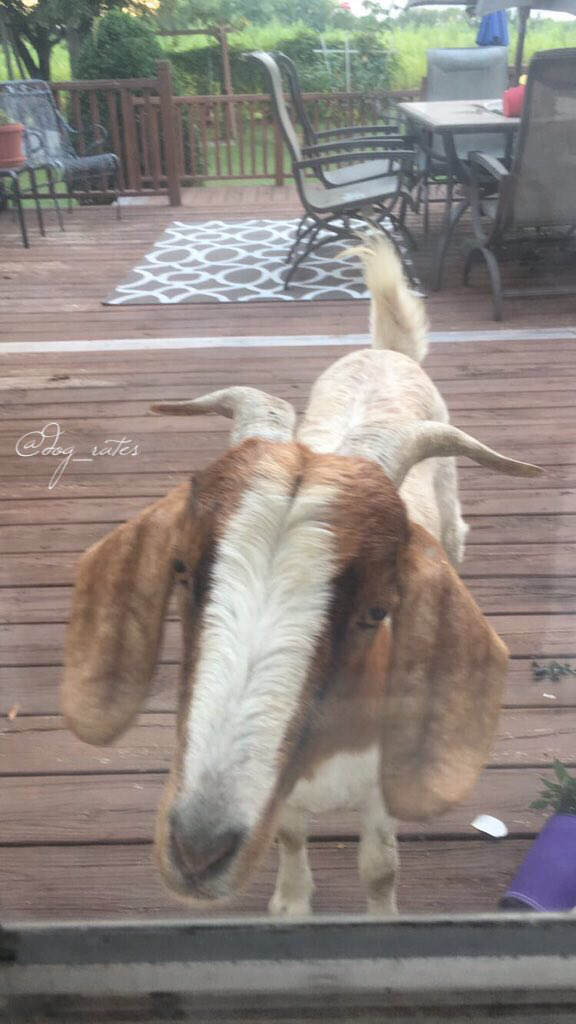

In [244]:
image_data=requests.get(twitter_archive_master[rating_numerator<10].images_urls.sample().values[0][0])
image = Image.open(io.BytesIO(image_data.content))
image

It's a goat, so maybe that's why it's got a rating lower than 10. 

And by checking some of these tweets i found that the majority of them are not of dogs.So, i choose to drop these and stick with one rating style which is 10 for the denominator and >=10 for the numerator 

In [546]:
rating_numerator=rating_numerator[rating_numerator>=10]
twitter_archive_master=twitter_archive_master.loc[rating_numerator.index]

We still got some outliers which are the values larger than 14.

In [547]:
rating_numerator.value_counts().sort_index()

10      421
11      402
12      452
13      258
14       35
24        1
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [548]:
twitter_archive_master[rating_numerator>14]

,id_str,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,in_reply_to_status_id_str,predicted_breed,algorithm_confidence,rating_numerator,rating_denominator,name,dog_stage
381,810984652412424192,https://t.co/LouL5vdvxx,2016-12-19 23:06:23+00:00,Meet Sam. She smiles 24/7 &amp; secretly aspir...,143,Twitter for iPhone,1491,5524,[https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg],None,golden_retriever,0.871342,24,7,Sam,None
499,786709082849828864,https://t.co/yBO5wuqaPS,2016-10-13 23:23:56+00:00,"This is Logan, the Chow who lived. He solemnly...",104,Twitter for iPhone,6334,18831,[https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg],None,pomeranian,0.467321,75,10,Logan,None
548,778027034220126208,https://t.co/QFaUiIHxHq,2016-09-20 00:24:34+00:00,This is Sophie. She's a Jubilant Bush Pupper. ...,137,Twitter for iPhone,1669,6738,[https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg],None,clumber_spaniel,0.946718,27,10,Sophie,pupper
720,749981277374128128,https://t.co/GRXwMxLBkh,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af....,54,TweetDeck,2498,5207,[https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg],None,None,NaN,1776,10,Atticus,None
1368,680494726643068929,https://t.co/eNm2S6p9BD,2015-12-25 21:06:00+00:00,Here we have uncovered an entire battalion of ...,106,Twitter for iPhone,488,1743,[https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg],None,kuvasz,0.438627,26,10,None,None
1711,670842764863651840,https://t.co/yfAAo1gdeY,2015-11-29 05:52:33+00:00,After so many requests... here you go.\n\nGood...,81,Twitter for iPhone,8462,24087,[https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg],None,None,NaN,420,10,None,None


By checking them manually.

In [549]:
rating_numerator[381] = None # this tweet has no rating 
rating_numerator[499] = 13 # WeRateDogs mentioned this tweet's rating in the comments which is equal 13
rating_numerator[548] = 11 # this tweet has a rating of  11.27 and i choose to round it as 11 
rating_numerator[720] = None # ambiguous rating and i choose to drop this one
rating_numerator[1368] = 11 # this tweet has a rating of  11.26 and i choose to round it as 11 
rating_numerator[1711] = None # this tweet rates snoop dogg,and i choose to drop this one 


In [550]:
rating_numerator.value_counts().sort_index() 

10.0    421
11.0    404
12.0    452
13.0    259
14.0     35
Name: rating_numerator, dtype: int64

In [551]:
rating_denominator=rating_denominator.loc[rating_numerator.index]

In [552]:
twitter_archive_master['rating_denominator'] = rating_denominator
twitter_archive_master['rating_numerator'] = rating_numerator


In [553]:
twitter_archive_master.dropna(subset=['rating_numerator','rating_denominator'],inplace=True)

**Test**

In [554]:
twitter_archive_master.rating_numerator.unique()

array([13., 12., 14., 11., 10.])

In [555]:
twitter_archive_master.rating_denominator.unique()

array([10.])

Since the rating_denominator is of one value i am goning to drop it.

In [556]:
twitter_archive_master.drop(columns='rating_denominator',inplace=True)

Changing the data type of rating_numerator from float to categorical.

In [557]:
twitter_archive_master.rating_numerator = twitter_archive_master.rating_numerator.astype('int').astype('category')

Dropping in_reply_to_status_id_str column cause it's of no use anymore.

In [558]:
twitter_archive_master.drop(columns='in_reply_to_status_id_str',inplace=True)

Dropping all rows that has None predicted_breed value. 

In [559]:
twitter_archive_master.dropna(subset=['predicted_breed'],inplace=True)

These are the wrong dog names.They all start with lowercases .

In [561]:
twitter_archive_master[twitter_archive_master.name.apply(lambda x : re.findall(r'^[A-Z].*',x)).explode().isna()].name.unique()

array(['a', 'quite', 'one', 'incredibly', 'my', 'not', 'just', 'getting',
       'very', 'all', 'infuriating', 'actually', 'officially', 'the',
       'light', 'space', 'an'], dtype=object)

As we see from one of these tweet's full text that no name is mentioned. so i am going to set all these names as None. 

In [562]:
twitter_archive_master[twitter_archive_master.name.apply(lambda x : re.findall(r'^[A-Z].*',x)).explode().isna()].full_text.iloc[10]

'This is just downright precious af. 12/10 for both pupper and doggo'

**Define**
> Replacing the wrong names with None and the names with string 'None' to None.

**Code**

In [563]:
wrong_names = twitter_archive_master[twitter_archive_master.name.apply(lambda x : re.findall(r'^[A-Z].*',x)).explode().isna()].name
wrong_names = set(wrong_names)

In [564]:
wrong_names.add('None')

In [565]:
twitter_archive_master.name=twitter_archive_master.name.apply(lambda x:None if x in wrong_names else x)

**test**

No intersect between the two sets, so we got rid of the wrong  names.

In [566]:
set(twitter_archive_master.name.unique()) & wrong_names

set()

**Define** 
> rename columns that needed to be renamed to more descriptive names and then reindex the DataFrame.

**Code**

In [567]:
twitter_archive_master.rename(columns={'id_str':'tweet_id',
                                       'name':'dog_name',
                                       'rating_denominator':'rating_out_of_10'},inplace=True)

In [568]:
twitter_archive_master.reset_index(drop=True,inplace=True)

**Test**

In [570]:
twitter_archive_master

,tweet_id,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,predicted_breed,algorithm_confidence,rating_numerator,dog_name,dog_stage
0,892177421306343426,https://t.co/0Xxu71qeIV,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,138,Twitter for iPhone,5795,31609,[https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg],chihuahua,0.323581,13,Tilly,None
1,891815181378084864,https://t.co/wUnZnhtVJB,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,121,Twitter for iPhone,3835,23812,[https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg],chihuahua,0.716012,12,Archie,None
2,891689557279858688,https://t.co/tD36da7qLQ,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,79,Twitter for iPhone,7993,40024,[https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg],labrador_retriever,0.168086,13,Darla,None
3,891327558926688256,https://t.co/AtUZn91f7f,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,138,Twitter for iPhone,8626,38213,[https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.j...,basset_hound,0.555712,12,Franklin,None
4,891087950875897856,https://t.co/kQ04fDDRmh,2017-07-29 00:08:17+00:00,Here we have a majestic great white breaching ...,138,Twitter for iPhone,2878,19226,[https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg],chesapeake_bay_retriever,0.425595,13,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,666102155909144576,https://t.co/11LvqN4WLq,2015-11-16 03:55:04+00:00,Oh my. Here you are seeing an Adobe Setter giv...,128,Twitter for iPhone,11,73,[https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg],english_setter,0.298617,11,None,None
1396,666073100786774016,https://t.co/Yk6GHE9tOY,2015-11-16 01:59:36+00:00,Let's hope this flight isn't Malaysian (lol). ...,137,Twitter for iPhone,147,302,[https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg],treeing_walker_coonhound,0.260857,10,None,None
1397,666063827256086533,https://t.co/RhUEAloehK,2015-11-16 01:22:45+00:00,This is the happiest dog you will ever see. Ve...,107,Twitter for iPhone,200,451,[https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg],golden_retriever,0.775930,10,None,None
1398,666055525042405380,https://t.co/rdivxLiqEt,2015-11-16 00:49:46+00:00,Here is a Siberian heavily armored polar bear ...,140,Twitter for iPhone,224,414,[https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg],chow_chow,0.692517,10,None,None


**Define**
> Joining akc_breeds with twitter_archive_master on predicted_breed column.

**Code**

In [571]:
twitter_archive_master = twitter_archive_master.join(akc_breeds_clean.set_index('breed'),on='predicted_breed')

**Test**

In [812]:
twitter_archive_master

,tweet_id,tweet_url,created_at,full_text,tweet_length,source,retweet_count,favorite_count,images_urls,predicted_breed,algorithm_confidence,rating_numerator,dog_name,dog_stage,breed_url,breed_image,breed_group,weight,height,life_expectancy,breed_temperament,pdf_breed_standard,akc_breed_popularity
0,892177421306343426,https://t.co/0Xxu71qeIV,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,138,Twitter for iPhone,5795,31609,[https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg],chihuahua,0.323581,13,Tilly,None,https://www.akc.org/dog-breeds/chihuahua/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Toy Group,not exceeding 6 pounds,5-8 inches,15.0,"[Charming, Graceful, Sassy]",http://images.akc.org/pdf/breeds/standards/Chi...,33
1,891815181378084864,https://t.co/wUnZnhtVJB,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,121,Twitter for iPhone,3835,23812,[https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg],chihuahua,0.716012,12,Archie,None,https://www.akc.org/dog-breeds/chihuahua/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Toy Group,not exceeding 6 pounds,5-8 inches,15.0,"[Charming, Graceful, Sassy]",http://images.akc.org/pdf/breeds/standards/Chi...,33
2,891689557279858688,https://t.co/tD36da7qLQ,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,79,Twitter for iPhone,7993,40024,[https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg],labrador_retriever,0.168086,13,Darla,None,https://www.akc.org/dog-breeds/labrador-retrie...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Sporting Group,"65-80 pounds (male), 55-70 pounds (female)","22.5-24.5 inches (male), 21.5-23.5 inches (fem...",11.0,"[Friendly, Active, Outgoing]",http://images.akc.org/pdf/breeds/standards/Lab...,1
3,891327558926688256,https://t.co/AtUZn91f7f,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,138,Twitter for iPhone,8626,38213,[https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.j...,basset_hound,0.555712,12,Franklin,None,https://www.akc.org/dog-breeds/basset-hound/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Hound Group,40-65 pounds,up to 15 inches,12.5,"[Charming, Patient, Low-Key]",http://images.akc.org/pdf/breeds/standards/Bas...,39
4,891087950875897856,https://t.co/kQ04fDDRmh,2017-07-29 00:08:17+00:00,Here we have a majestic great white breaching ...,138,Twitter for iPhone,2878,19226,[https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg],chesapeake_bay_retriever,0.425595,13,None,None,https://www.akc.org/dog-breeds/chesapeake-bay-...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Sporting Group,"65-80 pounds (male), 55-70 pounds (female)","23-26 inches (male), 21-24 inches (female)",11.5,"[Affectionate, Bright, Sensitive]",http://images.akc.org/pdf/breeds/standards/Che...,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,666102155909144576,https://t.co/11LvqN4WLq,2015-11-16 03:55:04+00:00,Oh my. Here you are seeing an Adobe Setter giv...,128,Twitter for iPhone,11,73,[https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg],english_setter,0.298617,11,None,None,https://www.akc.org/dog-breeds/english-setter/,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Sporting Group,"65-80 pounds (male), 45-55 pounds (female)","25-27 inches (male), 23-25 inches (female)",12.0,"[Friendly, Mellow, Merry]",http://images.akc.org/pdf/breeds/standards/Eng...,94
1396,666073100786774016,https://t.co/Yk6GHE9tOY,2015-11-16 01:59:36+00:00,Let's hope this flight isn't Malaysian (lol). ...,137,Twitter for iPhone,147,302,[https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg],treeing_walker_coonhound,0.260857,10,None,None,https://www.akc.org/dog-breeds/treeing-walker-...,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,Hound Group,50-70 pounds,"22-27 inches (male), 20-25 inches (female)",12.5,"[Smart, Brave, Courteous]",http://images.akc.org/pdf/breeds/standards/Tre...,137
1397,666063827256086533,https://t.co/RhUEAloehK,2015-11-16 01:22:45+00:00,This 

In [575]:
twitter_archive_master.to_csv(index=False,path_or_buf = 'twitter_archive_master.csv')

<a id='analize'></a>
## Analyzing and Visualizing

In [578]:
twitter_archive_master.shape[0]

1400

We've gotta 1400 tweet in our data.

In [814]:
twitter_archive_master.favorite_count.idxmax(),twitter_archive_master.retweet_count.idxmax()

(662, 662)

The same tweet has the largest favorite count and the largest retweet count.

Tweet full text: Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad)
The predicted dog breed: labrador_retriever
The weight of the predicted dog breed: 65-80 pounds (male), 55-70 pounds (female)
The height predicted dog breed: 22.5-24.5 inches (male), 21.5-23.5 inches (female)
The life expectancy of the predicted dog breed: 11.0 years
The predicted dog breed temperament: Friendly, Active, Outgoing
AKC predicted breed popularity: 1


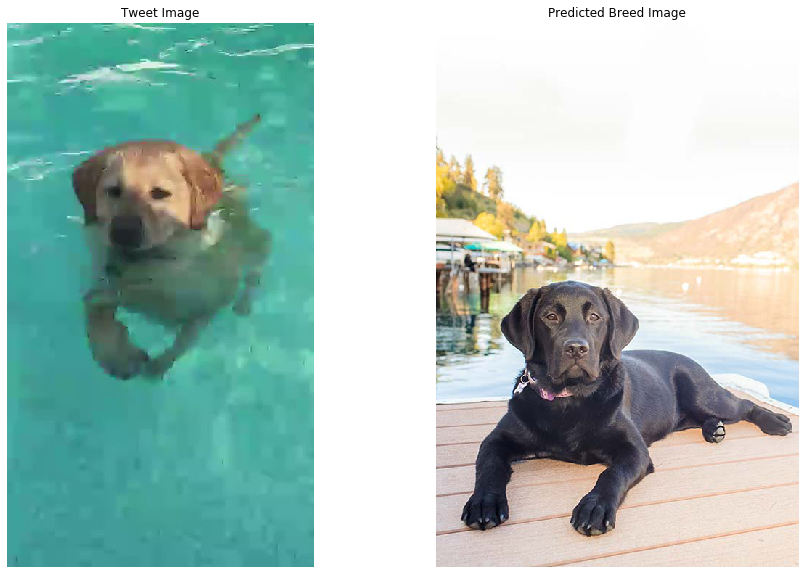

In [853]:
print('Tweet full text:',twitter_archive_master.loc[662].full_text)
print('The predicted dog breed:',twitter_archive_master.loc[662].predicted_breed)
print('The weight of the predicted dog breed:',twitter_archive_master.loc[662].weight)
print('The height predicted dog breed:',twitter_archive_master.loc[662].height)
print('The life expectancy of the predicted dog breed:',twitter_archive_master.loc[662].life_expectancy,'years')
print('The predicted dog breed temperament:',','.join(twitter_archive_master.loc[662].breed_temperament))
print('AKC predicted breed popularity:',twitter_archive_master.loc[662].akc_breed_popularity)

image_1 = requests.get(twitter_archive_master.loc[662].images_urls[0])
image_1 = Image.open(io.BytesIO(image_1.content))
image_2 = requests.get(twitter_archive_master.loc[662].breed_image)
image_2 = Image.open(io.BytesIO(image_2.content))
fig,ax=plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(image_1)
ax[0].axis('off')
ax[0].set_title('Tweet Image')
ax[1].imshow(image_2)
ax[1].axis('off')
ax[1].set_title('Predicted Breed Image');

Cool, i think the algorithm did a great job for this one .

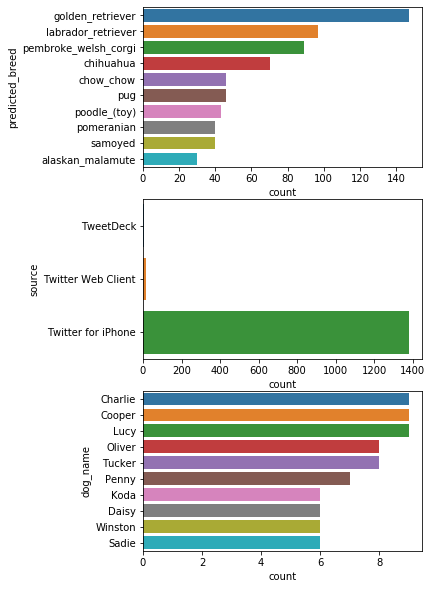

In [615]:
figure,ax = plt.subplots(3,1,figsize = (5,10) )
order_breed = twitter_archive_master.predicted_breed.value_counts().head(10).index
order_name = twitter_archive_master.dog_name.value_counts().head(10).index
sns.countplot(y = twitter_archive_master.predicted_breed,order = order_breed,ax = ax[0])
sns.countplot(y = twitter_archive_master.source,ax = ax[1])
sns.countplot(y = twitter_archive_master.dog_name ,order = order_name ,ax = ax[2]);


- **Charlie,Cooper and Lucy are the most frequent names in our data.**
- **WeRateDogs rarely uses other sources than their phone to tweet.**
- **Golden retriver is the most predicted dog breed in our data.**

____________________________________

A word cloud of the dog names.

In [782]:
mask = np.array(Image.open('./golden_retriever.jpg'))


In [787]:
for z in range(mask.shape[2]):
    for y in range(mask.shape[1]):
        for x in range(mask.shape[0]):
            if mask[x,y,z] == 0:
                mask[x,y,z] = 255
            else:
                pass 
            
    


In [793]:
wc = WordCloud(background_color="white", max_words=1000, mask=mask,
               max_font_size=90, random_state=42,contour_color='steelblue')
wc.generate(twitter_archive_master.dog_name.str.cat(sep=' '));


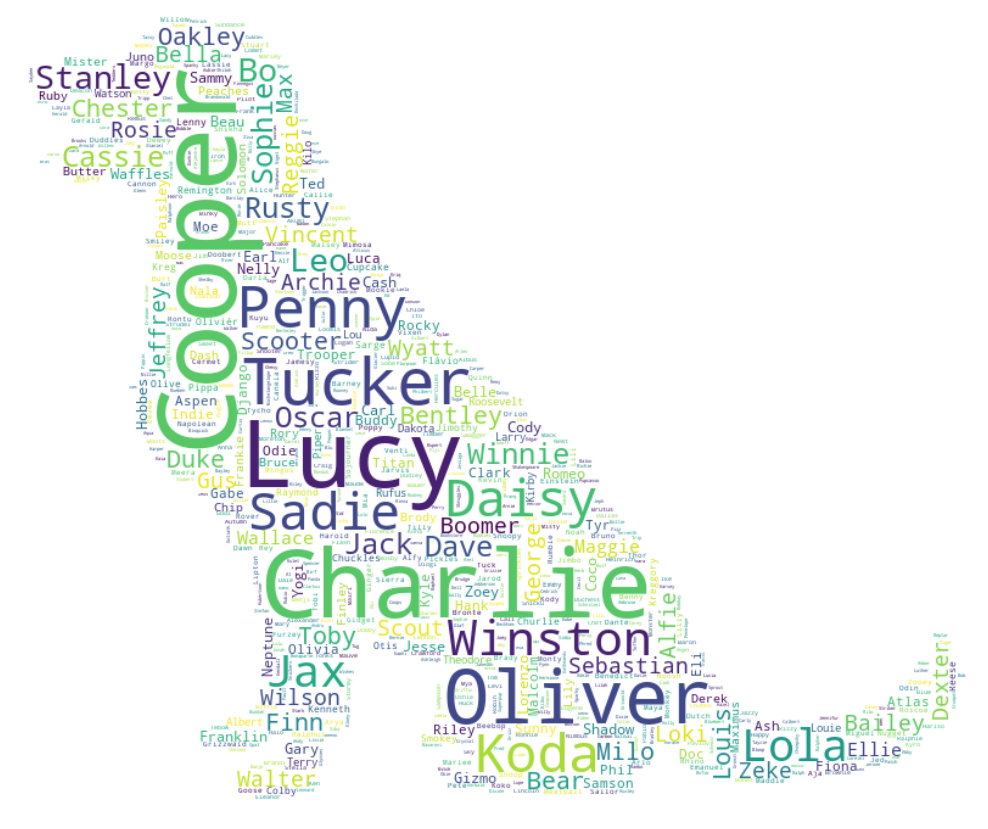

In [795]:
plt.figure(figsize=(20,15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()